# Project 6: Transformer Parsing

In this project, we implement a Transformer encoder and apply it to a constituency parser. It is trained to classify span labels, and we use the CKY algorithm to turn the predictions into trees.



In [ ]:
from copy import deepcopy
import json
import math
import random
import numpy as np
import sentencepiece
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import tqdm.notebook
import matplotlib.pyplot as plt
import nltk
from nltk.corpus.reader.bracket_parse import BracketParseCorpusReader
import svgling
svgling.disable_nltk_png()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data

We use the standard Penn Treebank data splits for parsing: sections 2 to 21 for training, section 22 for validation, and section 23 for testing.

In [ ]:
%%bash
if [ ! -e parsing-data.zip ]; then
  wget --quiet https://storage.googleapis.com/cs288-parsing-project/parsing-data.zip
fi
rm -rf train dev test EVALB/
unzip parsing-data.zip

In [ ]:
READER = BracketParseCorpusReader('.', ['train', 'dev', 'test'])

## Vocabulary

We preprocess the tree data into standard sentences that can be tokenized and input into a neural model.

In [ ]:
with open('sentences.txt', 'w') as f:
  for sent in READER.sents('train'):
    f.write(' '.join(sent) + '\n')

In [ ]:
args = {
    "pad_id": 0,
    "bos_id": 1,
    "eos_id": 2,
    "unk_id": 3,
    "input": "sentences.txt",
    "vocab_size": 16000,
    "model_prefix": "ptb",
}
combined_args = " ".join(
    "--{}={}".format(key, value) for key, value in args.items())
sentencepiece.SentencePieceTrainer.Train(combined_args)

In [ ]:
VOCAB = sentencepiece.SentencePieceProcessor()
VOCAB.Load("ptb.model")

In [ ]:
PAD_ID = VOCAB.PieceToId("<pad>")
BOS_ID = VOCAB.PieceToId("<s>")
EOS_ID = VOCAB.PieceToId("</s>")
UNK_ID = VOCAB.PieceToId("<unk>")

## Part-of-Speech Tagging Setup

We implement POS tagging as a way to create the baseline, single-word-span that can be recursively operated on to produce full constituency tagging tables.

Sentences are encoded at the subword level, which is translated to the word level by choosing the last subword as a word representation, masking the other tokens.

In [ ]:
def encode_sentence(sent):
  """Subword tokenization of an input sentence.

  Args:
    sent: a list of strings of words in the sentence
  Returns:
    A tuple (ids, is_word_end).
      ids: a list of token ids in the subword vocabulary
      is_word_end: a list of bools, where True indicates that the token
        is the last of the word
  """
  ids = []
  is_word_end = []
  for word in sent:
    word_ids = VOCAB.EncodeAsIds(word)
    ids.extend(word_ids)
    is_word_end.extend([False] * (len(word_ids) - 1) + [True])
  return ids, is_word_end

Downloading the PennTreebank tagset for training.

In [ ]:
nltk.download('tagsets')
nltk.help.upenn_tagset()

We get all possible POS tags in the data.

In [ ]:
def get_pos_vocab():
  all_pos = set()
  for sent in READER.tagged_sents('train'):
    for word, pos in sent:
      all_pos.add(pos)
  return sorted(all_pos)

PARTS_OF_SPEECH = get_pos_vocab()

We implement the `POSTaggingDataset` for input into a model.

Each example in the dataset is a feature dictionary, consisting of word piece `ids`, and corresponding label ids `labels`. Masked subword labels (non-ending tokens) have mask label -1.

We also define a `collate` function that pads examples for a batch.

In [ ]:
class POSTaggingDataset(torch.utils.data.Dataset):
  def __init__(self, split):
    assert split in ('train', 'dev', 'test')
    self.sents = READER.tagged_sents(split)
    if split == 'train':
      # To speed up training, we only train on short sentences.
      self.sents = [sent for sent in self.sents if len(sent) <= 40]

  def __len__(self):
    return len(self.sents)

  def __getitem__(self, index):
    sent = self.sents[index]
    ids, is_word_end = encode_sentence([word for word, pos in sent])
    ids = [BOS_ID] + ids + [EOS_ID]
    is_word_end = [False] + is_word_end + [False]
    ids = torch.tensor(ids)
    is_word_end = torch.tensor(is_word_end)
    labels = torch.full_like(ids, -1)
    labels[is_word_end] = torch.tensor(
        [PARTS_OF_SPEECH.index(pos) for word, pos in sent])
    return {'ids': ids, 'labels': labels}

  @staticmethod
  def collate(batch):
    ids = pad_sequence(
        [item['ids'] for item in batch],
        batch_first=True, padding_value=PAD_ID)
    labels = pad_sequence(
        [item['labels'] for item in batch],
        batch_first=True, padding_value=-1)
    return {'ids': ids.to(device), 'labels': labels.to(device)}

## Baseline POS Tagging Model

We implement the baseline tagging model that will serve as the base for the Transformer architecture.

In [ ]:
class POSTaggingModel(nn.Module):
  def encode(self, batch):
    raise NotImplementedError()

  def compute_loss(self, batch):
    logits = self.encode(batch)
    logits = logits.reshape((-1, logits.shape[-1]))
    labels = batch['labels'].reshape((-1,))
    res = F.cross_entropy(logits, labels, ignore_index=-1, reduction='mean')
    return res
  
  def get_validation_metric(self, batch_size=8):
    dataset = POSTaggingDataset('dev')
    data_loader = torch.utils.data.DataLoader(
      dataset, batch_size=batch_size, collate_fn=dataset.collate)
    self.eval()
    correct = 0
    total = 0
    with torch.no_grad():
      for batch in data_loader:
        mask = (batch['labels'] != -1)
        predicted_labels = self.encode(batch).argmax(-1)
        predicted_labels = predicted_labels[mask]
        gold_labels = batch['labels'][mask]
        correct += (predicted_labels == gold_labels).sum().item()
        total += gold_labels.shape[0]
    return correct / total

We use a warmup learning rate schedule, where the learning rate is increased linearly from 0 to its maximum value during a warm-up phase, and is then decayed as training progresses.

In [ ]:
def train(model, num_epochs, batch_size, model_file,
          learning_rate=8e-4, dataset_cls=POSTaggingDataset):
  """Train the model and save the one with best validation loss."""
  dataset = dataset_cls('train')
  data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, collate_fn=dataset.collate)
  optimizer = torch.optim.Adam(
      model.parameters(),
      lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(
      optimizer,
      learning_rate,
      epochs=num_epochs,
      steps_per_epoch=len(data_loader),
      pct_start=0.02,  # Warm up for 2% of the total training time
      )
  best_metric = 0.0
  for epoch in tqdm.notebook.trange(num_epochs, desc="training", unit="epoch"):
    with tqdm.notebook.tqdm(
        data_loader,
        desc="epoch {}".format(epoch + 1),
        unit="batch",
        total=len(data_loader)) as batch_iterator:
      model.train()
      total_loss = 0.0
      for i, batch in enumerate(batch_iterator, start=1):
        optimizer.zero_grad()
        loss = model.compute_loss(batch)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        batch_iterator.set_postfix(mean_loss=total_loss / i)
      validation_metric = model.get_validation_metric()
      batch_iterator.set_postfix(
          mean_loss=total_loss / i,
          validation_metric=validation_metric)
      if validation_metric > best_metric:
        print(
            f"Obtained a new best validation metric of {validation_metric}, saving model "
            f"checkpoint to {model_file}...")
        torch.save(model.state_dict(), model_file)
        best_metric = validation_metric
  print(f"Reloading best model checkpoint from {model_file}...")
  model.load_state_dict(torch.load(model_file))

Define a function that returns the predicted tags themselves.

In [ ]:
def predict_tags(tagging_model, split, limit=None):
  assert split in ('dev', 'test')
  sents = READER.sents(split)
  dataset = POSTaggingDataset(split)
  data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=False, collate_fn=dataset.collate)
  tagging_model.eval()
  pred_tagged_sents = []
  with torch.no_grad():
    for batch in data_loader:
      mask = (batch['labels'] != -1)
      predicted_labels = tagging_model.encode(batch).argmax(-1)
      for i in range(batch['ids'].shape[0]):
        example_predicted_tags = [
            PARTS_OF_SPEECH[label] for label in predicted_labels[i][mask[i]]]
        sent = sents[len(pred_tagged_sents)]
        assert len(sent) == len(example_predicted_tags)
        pred_tagged_sents.append(list(zip(sent, example_predicted_tags)))
        if limit is not None and len(pred_tagged_sents) >= limit:
          return pred_tagged_sents
  return pred_tagged_sents

## Transformer POS Tagging Model

We now implement a standard Transformer encoder.

The first part is multi-head self-attention. We:
- Apply linear projections to convert the feature vector at each token into separate vectors for the query, key, and value.
- Apply attention, scaling the logits by $\frac{1}{sqrt(d_{qkv})}$.
- Mask padding tokens so they are never attended to
- Perform attention `n_head` times in parallel, where the results are concatenated and then projected using a linear layer

We include two types of dropout:
- the output of the attention layer (just prior to the residual connection)
- the attention probabilites, right after the softmax operation that's applied to query-key dot products

We start with the multi-head attention.

In [ ]:
import pdb

class MultiHeadAttention(nn.Module):
  def __init__(self, d_model=256, n_head=4, d_qkv=32, dropout=0.1, **kwargs):
    super().__init__()
    self.d_model = d_model
    self.n_head = n_head
    self.d_qkv = d_qkv

    self.w_q = nn.Parameter(torch.Tensor(n_head, d_model, d_qkv))
    self.w_k = nn.Parameter(torch.Tensor(n_head, d_model, d_qkv))
    self.w_v = nn.Parameter(torch.Tensor(n_head, d_model, d_qkv))
    self.w_o = nn.Parameter(torch.Tensor(n_head, d_qkv, d_model))
    nn.init.xavier_normal_(self.w_q)
    nn.init.xavier_normal_(self.w_k)
    nn.init.xavier_normal_(self.w_v)
    nn.init.xavier_normal_(self.w_o)

    self.attn_drop = nn.Dropout(dropout)
    self.output_drop = nn.Dropout(dropout)
  
  def forward(self, x, mask):
    """Runs the multi-head self-attention layer.

    Args:
      x: the input to the layer, a tensor of shape [batch size, length, d_model]
      mask: a mask for disallowing attention to padding tokens.
    Returns:
      A single tensor containing the output from this layer
    """
    # [batch_size, n_head, seq_len, d_qkv]
    query = torch.einsum('ijk,mnj -> mink', self.w_q, x)
    key = torch.einsum('ijk,mnj -> mink', self.w_k, x)
    value = torch.einsum('ijk,mnj -> mink', self.w_v, x)

    # [batch_size, n_head, seq_len, seq_len]
    score = torch.einsum('ijkl,ijml -> ijkm', query, key)
    score /= np.sqrt(self.d_qkv)
    # assuming mask has shape [batch_size, seq_len], has 1s for unmasked tokens, and 0s for masked tokens
    #masked_score = torch.mul(score, mask.reshape(mask.shape[0], 1, 1, mask.shape[1]))

    # assuming mask has shape [batch_size, seq_len], has 1s for masked tokens, and 0s for unmasked tokens
    masked_score = score + mask.reshape(mask.shape[0], 1, 1, mask.shape[1])*-1e9
    attn = F.softmax(masked_score, -1)
    attn = self.attn_drop(attn)
  
    # [batch_size, n_head, seq_len, d_qkv]
    attn_output = torch.einsum('ijkl,ijlm -> ijkm', attn, value)

    # w_o: [n_head, d_qkv, d_model]
    # sum over heads and d_qkv: [batch_size, seq_len, d_model]
    output = torch.einsum('ijkl, jlm -> ikm', attn_output, self.w_o)
    output = self.output_drop(output)

    return output

We now implemennt the position-wise feed forward layer, consisting of two dense linear layers with ReLU nonlinearity in the middle.

In [ ]:
class PositionwiseFeedForward(nn.Module):
  def __init__(self, d_model, d_ff, dropout=0.1):
    super().__init__()
    self.linear1 = nn.Linear(d_model, d_ff)
    self.linear2 = nn.Linear(d_ff, d_model)
    self.drop = nn.Dropout(dropout)

  def forward(self, x):
    output = self.linear2(F.relu(self.linear1(x)))
    output = self.drop(output)

    return output

Combining the two gives the full transformer encoder architecture.

In [ ]:
class TransformerEncoder(nn.Module):
  def __init__(self, d_model=256, d_ff=1024, n_layers=4, n_head=4, d_qkv=32,
               dropout=0.1):
    super().__init__()
    self.mha_layers = nn.ModuleList([MultiHeadAttention(d_model=d_model, n_head=n_head, d_qkv=d_qkv)]*n_layers)
    self.pff_layers = nn.ModuleList([PositionwiseFeedForward(d_model=d_model, d_ff=d_ff)]*n_layers)

  def forward(self, x, mask):
    """Runs the Transformer encoder.

    Args:
      x: the input to the Transformer, a tensor of shape
         [batch size, length, d_model]
      mask: a mask for disallowing attention to padding tokens.
    Returns:
      A single tensor containing the output from the Transformer
    """

    # uses residual connections and layer norms at every multi-head attention
    #   and feed-forward layer
    for i, mha_layer in enumerate(self.mha_layers):
      x = F.layer_norm(self.mha_layers[i](x, mask)+x, x.shape)
      x = F.layer_norm(self.pff_layers[i](x)+x, x.shape)

    return x

We include positional encodings using a standard position-dependent context.

In [ ]:
class AddPositionalEncoding(nn.Module):
  def __init__(self, d_model=256, input_dropout=0.1, timing_dropout=0.1,
               max_len=512):
    super().__init__()
    self.timing_table = nn.Parameter(torch.FloatTensor(max_len, d_model))
    nn.init.normal_(self.timing_table)
    self.input_dropout = nn.Dropout(input_dropout)
    self.timing_dropout = nn.Dropout(timing_dropout)
  
  def forward(self, x):
    """
    Args:
      x: A tensor of shape [batch size, length, d_model]
    """
    x = self.input_dropout(x)
    timing = self.timing_table[None, :x.shape[1], :]
    timing = self.timing_dropout(timing)
    return x + timing

Combining everything:

In [ ]:
class TransformerPOSTaggingModel(POSTaggingModel):
  def __init__(self):
    super().__init__()
    d_model = 256
    self.add_timing = AddPositionalEncoding(d_model)
    self.encoder = TransformerEncoder(d_model)
    self.vocab_size = 16000
    self.embed = nn.Embedding(self.vocab_size, d_model)
    self.out = nn.Linear(d_model, self.vocab_size)

  def encode(self, batch):
    """
    Args:
      batch: an input batch as a dictionary; the key 'ids' holds the vocab ids
        of the subword tokens in a tensor of size [batch_size, sequence_length]
    Returns:
      A single tensor containing logits for each subword token.
    """
    mask = (batch['ids']==PAD_ID)

    embedded = self.embed(batch['ids'])
    positions = self.add_timing(embedded)
    encoded = self.encoder(positions, mask)
    encoded = F.layer_norm(encoded, encoded.shape)
    output = self.out(encoded)

    return output

In [ ]:
num_epochs = 8
batch_size = 16

tagging_model = TransformerPOSTaggingModel().to(device)
train(tagging_model, num_epochs, batch_size, "tagging_model.pt")

## Parsing Setup

We now implement a parser as a span classification task. Each span in the sentence (that is, each combination of start and end position) will be assigned a label. Constituents will be labeled with their syntactic category, while non-constituents will recieve a special null label.

The span "playing tennis" is simultaneously a verb phrase (VP) and a nested clause (S). To resolve this issue, we introduce a special chain label "S+VP" for this situation.

The function `collapse_unary_strip_pos` transforms trees to collapse such unary chains. It also strips part-of-speech labels (which can be predicted by the tagger in the previous part of this project), as well as the root label "TOP".

In [ ]:
def collapse_unary_strip_pos(tree):
  def strip_pos(tree):
    if len(tree) == 1 and isinstance(tree[0], str):
      return tree[0]
    else:
      return nltk.tree.Tree(tree.label(), [strip_pos(child) for child in tree])
  collapsed_tree = strip_pos(tree)
  collapsed_tree.collapse_unary(collapsePOS=True)
  if collapsed_tree.label() == 'TOP' and len(collapsed_tree) == 1:
    collapsed_tree = collapsed_tree[0]
  return collapsed_tree 

Child 0 is: (NP She)


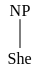

Child 1 is: (VP enjoys (S+VP playing (NP tennis)))


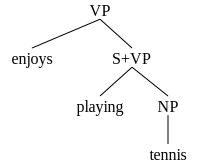

Child 1 label is: VP


In [ ]:
print('Child 0 is:', collapsed_tree[0])
display(collapsed_tree[0])
print('Child 1 is:', collapsed_tree[1])
display(collapsed_tree[1])
print('Child 1 label is:', collapsed_tree[1].label())

We first implement an `encode_tree` function that maps from Tree objects to sets of spans with labels and starting/end positions. The span start/end position will be defined in terms of subword positions. The start position is inclusive and the end is exclusive.

In [ ]:
from collections import defaultdict
  
def encode_tree(tree):
  """Converts a tree into subword token ids and a list of labeled spans.

  Args:
    tree: an nltk.tree.Tree object

  Returns:
    A tuple (ids, is_word_end, spans)
      ids: a list of token ids in the subword vocabulary
      is_word_end: a list of bools indicating if the token is the last in the word
      spans: a list of tuples of form (start, end, label), where `start` is
             the position in ids where the span starts, `end` is the ending
             point in the span (exclusive), and `label` is a string indicating
             the syntactic label for the constituent.
  """
  tree = collapse_unary_strip_pos(tree)

  # get ids and is_word_end
  sent = tree.leaves()
  ids = []
  is_word_end = []

  for word in sent:
    word_ids = VOCAB.EncodeAsIds(word)
    ids.extend(word_ids)
    is_word_end.extend([False] * (len(word_ids) - 1) + [True])

  spans = []

  # fill out spans with DFS/pre-order traversal
  repeats = defaultdict(int)
  
  def visit_tree(tree):
    label = tree.label()
    tree_words = tree.leaves()
    tree_ids = []

    # do this to avoid some edge cases with duplicates
    for word in tree_words:
      word_ids = VOCAB.EncodeAsIds(word)
      tree_ids.extend(word_ids)
    
    # locate the words within the full sentence
    # there's probably a more efficient way to do this
    # handle dupes by tracking occurrences in dictionary
    span = [(i, i+len(tree_ids)) for i in range(len(ids)) if ids[i:i+len(tree_ids)] == tree_ids]
    valid_spans = [(x,y) for x,y in span if is_word_end[y-1]]
    if len(valid_spans) > 1:
      idx = repeats[tuple(tree_ids)]
      spans.append((valid_spans[idx][0], valid_spans[idx][1], label))
      repeats[tuple(tree_ids)] += 1
    else:
      spans.append((valid_spans[0][0], valid_spans[0][1], label))

    for subtree in tree:
       if type(subtree) == nltk.tree.Tree:
         visit_tree(subtree)

  visit_tree(tree)

  return ids, is_word_end, spans

We obtain a set of all span labels in the training data. We also introduce an `UNK` label. Finally, there is a null label to represent that a span is not a syntactic constituent. We then implement dataset object for the parsing task.

In [ ]:
SPAN_LABELS = set()
for tree in READER.parsed_sents('train'):
  _, _, spans = encode_tree(tree)
  for _, _, label in spans:
    SPAN_LABELS.add(label)
SPAN_LABELS.add('')
SPAN_LABELS.add('UNK')

In [ ]:
class ParsingDataset(torch.utils.data.Dataset):
  def __init__(self, split):
    assert split in ('train', 'dev', 'test')
    self.trees = READER.parsed_sents(split)
    if split == 'train':
      # To speed up training, we only train on short sentences.
      self.trees = [tree for tree in self.trees if len(tree.leaves()) <= 40]

  def __len__(self):
    return len(self.trees)

  def __getitem__(self, index):
    """ This function loads a single tree into tensors for 'ids', 'labels', and
    'is_word_end'.

    See 'collate' function below for a description of the batched version of the
    tensors to return.
    """

    tree = self.trees[index]
    ids, is_word_end, spans = encode_tree(tree)
    # adding beginning and ending tokens
    ids = [BOS_ID] + ids + [EOS_ID]
    ids = torch.LongTensor(ids)

    # creating the mask to pair ending subword tokens with full words
    is_word_end = [False] + is_word_end + [False]
    is_word_end = torch.LongTensor(is_word_end).bool()
    labels = torch.zeros(ids.shape[0], ids.shape[0])

    # setting diagonal, lower triangle, and first row to -1 for invalid spans
    lower_tri = torch.tril(torch.ones_like(labels)).bool()
    labels[lower_tri] = -1
    labels[0] = torch.full_like(ids, -1)

    for x, y, label in spans:
      if label in SPAN_SET:
        labels[x+1,y+1] = SPAN_LABELS.index(label)
      else:
        labels[x+1,y+1] = SPAN_LABELS.index('UNK')

    return {'ids' : ids, 'labels' : labels, 'is_word_end' : is_word_end}

  @staticmethod
  def collate(batch):
    """ This function takes a list of examples as output by your __getitem__
    function and turns them into batched tensors.
    
    Returns:
      A dictionary with three keys.
      * 'ids' is a LongTensor of shape [batch_size, max_sentence_length]
      * 'labels' is a LongTensor of shape [batch_size, max_sentence_length, max_sentence_length]
        with labels[batch, i, j] representing the label of the span starting at
        subword position i and ending at subword position j (exclusive).
      * 'is_word_end' is bool tensor of shape [batch_size, max_sentence_length],
        with True values at the last sub-word piece for each word.
    """
    ids = pad_sequence([item['ids'] for item in batch], batch_first=True, padding_value=PAD_ID).long()
    is_word_end = pad_sequence([item['is_word_end'] for item in batch], batch_first=True, padding_value=False)

    max_length = 0
    for item in batch:
      max_length = max(max_length, item['labels'].shape[0])

    labels = []
    for item in batch:
      pad = max_length-item['labels'].shape[0]
      label_tensor = F.pad(item['labels'], (0, pad, 0, pad), value=-1)
      labels.append(label_tensor)

    labels = torch.stack(labels).long()

    return {
        'ids': ids.to(device),
        'labels': labels.to(device),
        'is_word_end': is_word_end.to(device),
        }


## Parsing Model

Now we implement the full parsing model.

In [ ]:
class ParsingModel(nn.Module):
  def encode(self, batch):
    raise NotImplementedError()

  def compute_loss(self, batch):
    raise NotImplementedError()

  def get_validation_metric(self):
    dataset = ParsingDataset('dev')
    data_loader = torch.utils.data.DataLoader(
      dataset, batch_size=8, collate_fn=dataset.collate)
    self.eval()
    total_gold_spans = 0
    total_predicted_spans = 0
    total_correct = 0
    with torch.no_grad():
      for batch in data_loader:
        mask = (batch['labels'] != -1)
        model_output = self.encode(batch)
        predicted_labels = model_output.argmax(-1)
        predicted_labels = predicted_labels[mask]
        gold_labels = batch['labels'][mask]

        total_gold_spans += (gold_labels != 0).sum().item()
        total_predicted_spans += (predicted_labels != 0).sum().item()
        total_correct += ((predicted_labels == gold_labels) & (gold_labels != 0)
            ).sum().item()

    if total_predicted_spans != 0:
      precision = total_correct / total_predicted_spans
    else:
      precision = 0.0
    recall = total_correct / total_gold_spans
    if precision == 0.0 or recall == 0.0:
      f1 = 0.0
    else:
      f1 = 2 * precision * recall / (precision + recall)
    # For convenience, we represent precion/recall/F1 as percentage points.
    precision *= 100
    recall *= 100
    f1 *= 100
    print(f"precision={precision:.2f} recall={recall:.2f} f1={f1:.2f}")
    return f1

The parser operates by:
- Running a Transformer encoder to produce a vector at each position in the sentence.
- Computing a vector for each span, by subtracting the vectors for the start and endpoints.
- Runing an MLP span classifier that takes these span vectors as input.

In [ ]:
class TransformerParsingModel(ParsingModel):
  def __init__(self):
    super().__init__()
    d_model = 256
    self.add_timing = AddPositionalEncoding(d_model)
    self.encoder = TransformerEncoder(d_model)
    self.vocab_size = 16000
    self.label_size = len(SPAN_LABELS)
    
    self.embed = nn.Embedding(self.vocab_size, d_model)
    self.linear1 = nn.Linear(d_model, d_model)
    self.linear2 = nn.Linear(d_model, d_model)
    self.drop1 = nn.Dropout(0.4)
    self.drop2 = nn.Dropout(0.1)
    self.out = nn.Linear(d_model, self.label_size)

  def encode(self, batch):
    """Returns logits for each label and each span in the sentence.
    
    Returns:
      A float tensor of shape [batch_size, length, length, len(SPAN_LABELS)],
      where the element at position [n, i, j, l] represents the score (logit) of
      assigning label l to the span beginning at subword position i and ending
      at position j (exclusive), for the n-th example in the batch.
    """
    mask = (batch['ids']==PAD_ID)

    embedded = self.embed(batch['ids'])
    positions = self.add_timing(embedded)
    encoded = self.encoder(positions, mask)
    span_vectors = encoded.reshape(encoded.shape[0], 1, encoded.shape[1], -1) - encoded.reshape(encoded.shape[0], encoded.shape[1], 1, -1)

    output = self.drop1(F.relu(self.linear1(span_vectors)))
    output = self.linear2(output)
    output = F.layer_norm(output, output.shape)
    output = self.drop2(output)
    output = self.out(output)

    return output
  
  def compute_loss(self, batch):
    """Compute the cross-entropy loss for training the model. -1 labels are
      passed over.
    """
    logits = self.encode(batch)
    labels = batch['labels']
    loss = F.cross_entropy(logits.permute(0, 3, 1, 2), labels, ignore_index=-1, reduction='mean')

    return loss

In [ ]:
num_epochs = 16
batch_size = 16

parsing_model = TransformerParsingModel().to(device)
train(parsing_model, num_epochs, batch_size, "parsing_model.pt",
      dataset_cls=ParsingDataset)

We implement a `predict` function will run your parser on batches from the dataset the uses CKY decoding to produce trees.

In [ ]:
def predict(parsing_model, split, tagging_model=None):
  assert split in ('dev', 'test')
  if tagging_model is None:
    tagged_sents = READER.tagged_sents(split)
  else:
    tagged_sents = predict_tags(tagging_model, split)
  
  label_scores_charts = predict_span_label_scores(parsing_model, split)

  pred_trees = []
  for tagged_sent, label_scores_chart in zip(tagged_sents, label_scores_charts):
    leaves = [nltk.tree.Tree(tag, [word]) for word, tag in tagged_sent]
    tree = cky_decode(leaves, label_scores_chart)
    tree = uncollapse_tree(tree)
    pred_trees.append(tree)
  return pred_trees


def predict_span_label_scores(parsing_model, split):
  assert split in ('dev', 'test')
  dataset = ParsingDataset(split)
  data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=False, collate_fn=dataset.collate)
  parsing_model.eval()
  all_label_scores_charts = []
  with torch.no_grad():
    for batch in data_loader:
      label_scores_charts = parsing_model.encode(batch)
      label_scores_charts = F.log_softmax(label_scores_charts, dim=-1) # Not necessary, but okay to keep. 
      for i in range(batch['ids'].shape[0]):
        label_scores_chart = label_scores_charts[i]

        # The data pipeline uses is_word_end for consistency with the part of
        # speech tagging models, but here we need is_word_start instead. Note
        # that because span endpoints use exclusive indexing, the index actually
        # points to the first subword in the next word.
        is_word_end = batch['is_word_end'][i]
        is_word_start = F.pad(is_word_end, (1, -1), value=False)
        is_word_start[1] = True

        # Extract scores for whole words only, ignoring any model decisions that
        # have a span start or end halfway through a word. Evaluation for
        # parsing typically uses the ground-truth tokenization from the dataset.
        label_scores_chart = label_scores_chart[
            is_word_start, : ,:][:, is_word_start, :]
        label_scores_chart = label_scores_chart.cpu().numpy()

        all_label_scores_charts.append(label_scores_chart)
  return all_label_scores_charts


def uncollapse_tree(tree):
  if isinstance(tree, str):
    return tree
  else:
    labels = tree.label().split('+')
    children = []
    for child in tree:
      child = uncollapse_tree(child)
      if isinstance(child, str) and (len(tree) > 1
                                     or labels[-1] not in PARTS_OF_SPEECH):
        child = nltk.tree.Tree('UNK', [child])
      children.append(child)
    for label in labels[::-1]:
      children = [nltk.tree.Tree(label, children)]
    return children[0]

The argmax model predictions are not guaranteed to be a valid tree: some of the spans may intersect with one another, which is not allowed in our syntactic formalism. We implement CKY decoding to find the highest-scoring tree under the model.

CKY is designed to handle binary trees, but some productions have greater than two children. For this project, we handle non-binary productions by allowing intermediate dummy nodes with a special null label, implemented in the code as an empty string '' at index 0 in SPAN_LABELS. We allow the algorithm to select spans with the null label, but then collapse them out when creating the tree.  

To avoid having high-probability null labels competing with non-null labels, we normalize our scores by subtracting the logit of the null label from the scores of all the labels. This normalization makes it so that if a local span decision would prefer a non-null label it will have positive score, and thus have higher score than all 0-score null labels.

In [ ]:
def cky_decode(leaves, label_scores_chart):
  label_scores_chart = torch.from_numpy(label_scores_chart)
  label_scores_chart = label_scores_chart - label_scores_chart[:,:,0].unsqueeze(-1)
  n = label_scores_chart.shape[0]
  pointers = torch.ones(n,n).long()*-1
  scores = torch.ones(n, n)*-1e9
  labels = torch.zeros(n,n).long()

  for i in range(n-1):
    scores[i, i+1], labels[i,i+1] = torch.max(label_scores_chart[i,i+1], 0)
    pointers[i,i+1] = i

  for diff in range(2,n):
    for i in range(0,n-diff):
      j = i + diff
      base_score, labels[i,j] = torch.max(label_scores_chart[i,j], 0)
      pointers[i,j] = i+1
      for k in range(i+1, j):
        split_score = scores[i,k] + scores[k,j]
        if scores[i,j] < base_score + split_score:
          scores[i,j] = base_score + split_score
          pointers[i,j] = k


  def constructTree(i,j):
    k = pointers[i,j]
    label_idx = labels[i,j]

    if j-i > 1:
      left_tree = constructTree(i,k)
      right_tree = constructTree(k,j)
      tree = nltk.tree.Tree(SPAN_LABELS[label_idx], [])
      
      if left_tree.label() == '':
        for child in left_tree:
          tree.append(child)
      else:
        tree.append(left_tree)
        
      if right_tree.label() == '':
        for child in right_tree:
          tree.append(child)
      else:
        tree.append(right_tree)

    else:
      subtree = [leaves[k]]
      tree = nltk.tree.Tree(SPAN_LABELS[label_idx], subtree)

    return tree

  tree = constructTree(0, n-1)

  return tree

In [ ]:
predicted_dev_trees = predict(parsing_model, 'dev')
predicted_dev_trees[10]

## Final evaluation

The standard evaluation for parsing is typically performed using the EVALB software (https://nlp.cs.nyu.edu/evalb/). 

The metrics reported by EVALB include:
- *Bracketing Recall*: Number of correct constituents divided by the number of constituents in the ground-truth data
- *Bracketing Precision*: Number of correct constituents divided by the number of constituents in the predicted trees
- *Bracketing FMeasure*: The F1 score, which is the harmonic mean of the Bracketing Recall and Bracketing Precision
- *Complete Match*: Percentage of sentences where recall and precision are both 100%
- *Average crossing*: Number of constituents crossing a ground-truth constituent divided by the number of sentences
- *No crossing*: Percentage of sentences which have 0 crossing brackets

Metrics are reported both for the full dataset and for the subset of sentences that have length 40 or shorter.

In [ ]:
# compile the EVALB program
!cd EVALB; make 

In [ ]:
with open('./dev_predictions_parser_only.txt', 'w') as f:
  for tree in predicted_dev_trees:
    f.write(' '.join(str(tree).split()) + '\n')

In [ ]:
!EVALB/evalb -p EVALB/nk.prm dev dev_predictions_parser_only.txt | tail -n 29